In [1]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import random
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, classification_report,confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from keras import losses,optimizers,utils
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Data pre-processing

In [2]:
with open('data.p', 'rb') as fp:
    data = pickle.load(fp)

In [3]:
seed =15
participants = list(data.keys())
random.seed(seed)
random.shuffle(participants)
p_train = participants[:100]
p_val = participants[100:125]
p_test = participants[125:145]

In [4]:
task = 'locomotion'

In [5]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = [],[],[],[],[],[]

In [6]:
for p1 in p_train:
    X_train.extend(data[p1][0])
    Y_train.extend(data[p1][1])
Y_train = np.asarray(Y_train,dtype=np.str)

for p2 in p_val:
    X_val.extend(data[p1][0])
    Y_val.extend(data[p1][1])
Y_val = np.asarray(Y_val,dtype=np.str)

for p3 in p_test:
    X_test.extend(data[p1][0])
    Y_test.extend(data[p1][1])
Y_test = np.asarray(Y_test,dtype=np.str)

In [7]:
Y_train = np.where(Y_train==task,1,0)
Y_val = np.where(Y_val==task,1,0)
Y_test = np.where(Y_test==task,1,0)

In [8]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [9]:
train_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
val_weights = class_weight.compute_class_weight('balanced',np.unique(Y_val),Y_val)

### keras model

In [10]:
inputs = Input(shape=(480,3))
conv1 = Conv1D(32, 8, strides =1 , padding='same', activation='relu')(inputs)
conv2 = Conv1D(32, 8, strides =1 , padding='same', activation='relu')(conv1)
lstm1 = LSTM(32)(conv2)
output = Dense(1,activation='sigmoid')(lstm1)
model = Model(inputs=inputs,outputs= output)

W0913 19:52:24.630378 140684457834304 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 19:52:24.638291 140684457834304 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 19:52:24.640146 140684457834304 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [20]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])
checkpoint = ModelCheckpoint('weight.h5', monitor='binary_accuracy',save_best_only=True,mode='max')
history = model.fit(X_train, Y_train,batch_size=32,validation_data=(X_val,Y_val),
          class_weight=train_weights,epochs=15,callbacks=[checkpoint])

Train on 68555 samples, validate on 20950 samples
Epoch 1/15
68555/68555 [==============================] - 303s 4ms/step - loss: 0.1749 - binary_accuracy: 0.9452 - val_loss: 0.3232 - val_binary_accuracy: 0.9010
Epoch 2/15
68555/68555 [==============================] - 298s 4ms/step - loss: 0.1690 - binary_accuracy: 0.9469 - val_loss: 0.3261 - val_binary_accuracy: 0.9033
Epoch 3/15
68555/68555 [==============================] - 306s 4ms/step - loss: 0.1623 - binary_accuracy: 0.9492 - val_loss: 0.3471 - val_binary_accuracy: 0.9033
Epoch 4/15
68555/68555 [==============================] - 306s 4ms/step - loss: 0.1570 - binary_accuracy: 0.9508 - val_loss: 0.2785 - val_binary_accuracy: 0.9177
Epoch 5/15
68555/68555 [==============================] - 293s 4ms/step - loss: 0.1508 - binary_accuracy: 0.9531 - val_loss: 0.2710 - val_binary_accuracy: 0.9212
Epoch 6/15
68555/68555 [==============================] - 292s 4ms/step - loss: 0.1461 - binary_accuracy: 0.9548 - val_loss: 0.2591 - val_bi

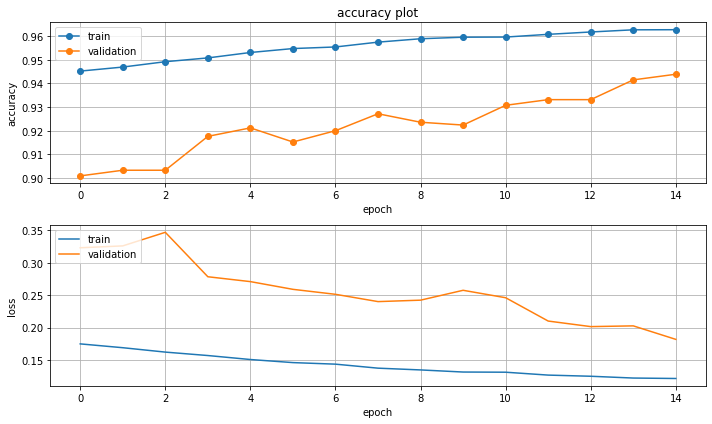

In [21]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(history.history['binary_accuracy'],marker='o')
plt.plot(history.history['val_binary_accuracy'],marker='o')
plt.grid(True)
plt.title('accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplot(212)
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()

In [22]:
Y_pred = model.predict(X_test,batch_size = 32)

In [23]:
fpr, tpr, thresholds=roc_curve(Y_test,Y_pred,pos_label=1)
area = auc(fpr,tpr)

In [24]:
print ('aUC = %0.2f' %area)

aUC = 0.92


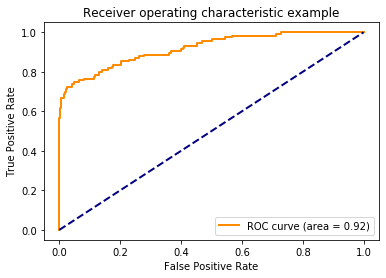

In [25]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' %area)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [26]:
Y_pred1 = Y_pred
Y_pred1[Y_pred>=0.5]=1
Y_pred1[Y_pred<0.5]=0
classes = ['non-locomotion','locomotion']
print(classification_report(Y_test,Y_pred,target_names=classes))

                precision    recall  f1-score   support

non-locomotion       0.94      0.99      0.97     14460
    locomotion       0.94      0.63      0.76      2300

      accuracy                           0.94     16760
     macro avg       0.94      0.81      0.86     16760
  weighted avg       0.94      0.94      0.94     16760



In [27]:
confusion_matrix(Y_test, Y_pred1)

array([[14360,   100],
       [  840,  1460]])

In [28]:
balanced_accuracy_score(Y_test, Y_pred1)

0.8139334896866919